# Business Understanding

### Background
In the entertainment industry, understanding audience sentiment is important for assessing film and series performance, improving content creation, and enhancing user satisfaction. IMDb, as a premier database for movie, TV, and celebrity content, is a rich source of user-generated reviews, offering deep insights into viewers' opinions and feelings about content.

### Problem Statement
There are vast amount of reviews in the IMDB database along with its rating but there are no emotions attached to the reviews.

### Objective
Our objective is to develop a machine learning model that can properly classify emotion of the user into 6 categories. This will help in analysis of audience reactions, trends and preferances

In [4]:
import pandas as pd
import selenium
from selenium import webdriver
import requests
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import re
import time
import numpy as np
from tqdm import tqdm
import os

### Web Scraping
For Web scraping we will be using selenium and beautiful soup as the libraries for scraping below are the steps followed for webscraping
* First Get all the 250 movie URLs and review urls from top 250 movies in IMDB website.
* Second Store all the movie Title, Year, Run Time, movie URL and movie review URL in an excel.
* Third Iterate through movie review URL and get all the user reviews and store it in an excel. 
                                                                            

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

#Setting up the Chrome WebDriver
s = Service()
options=webdriver.ChromeOptions()
driver = webdriver.Chrome(service=s,options=options)
# URL for the top 1000 movies sorted by user rating
url = 'https://www.imdb.com/chart/top/'

# Navigating to the URL
driver.get(url)
# Using WebDriverWait to wait for the element to be clickable
wait = WebDriverWait(driver, 10)  # Wait up to 10 seconds before timing out
button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="__next"]/div/div/div[2]/div/button[1]')))


# Click the element once it's clickable
button.click()

# Get the HTML content of the page
page_source = driver.page_source

# Initialize BeautifulSoup with the page source
soup = BeautifulSoup(page_source, 'html.parser')


driver.quit()

In [4]:
import re

In [5]:
# A function to convert runtime to minutes
def runtime_to_minutes(runtime_str):
    # Regular expression to extract hours and minutes
    match = re.match(r'(?:(\d+)h)?\s*(?:(\d+)m)?', runtime_str)
    if not match:
        return None  # Return None if the runtime_str doesn't match the expected format
    hours, minutes = match.groups()
    total_minutes = (int(hours) if hours else 0) * 60 + (int(minutes) if minutes else 0)
    return total_minutes

In [6]:
# Initialize a list to hold all movie data
movies = []

# Find all movie container elements - Adjust the selector as needed
movie_containers = soup.find_all('div', class_='ipc-metadata-list-summary-item__tc')
for movie in movie_containers:
    # Extract the title
    full_title = movie.a.h3.text.strip()
    title_page_url = movie.a.get('href').split('?')[0]
    user_reviews_url = f"https://www.imdb.com{title_page_url}reviews"
    #Using regex to remove digits in front of titles
    title = re.sub(r'^\d+\.\s*', '', full_title)
    
    details_spans = movie.find_all('span', class_='sc-b0691f29-8 ilsLEX cli-title-metadata-item')
    year = details_spans[0].text
    runtime = runtime_to_minutes(details_spans[1].text)
    movies.append({
            'Title': title,
            'Year': year,
            'Runtime(in mins)': runtime,
            'Page URL': f"https://www.imdb.com{title_page_url}",
            'User Reviews URL': user_reviews_url
        })    

movies_df = pd.DataFrame(movies)
display(movies_df)



,Title,Year,Runtime(in mins),Page URL,User Reviews URL
0,The Shawshank Redemption,1994,142,https://www.imdb.com/title/tt0111161/,https://www.imdb.com/title/tt0111161/reviews
1,The Godfather,1972,175,https://www.imdb.com/title/tt0068646/,https://www.imdb.com/title/tt0068646/reviews
2,The Dark Knight,2008,152,https://www.imdb.com/title/tt0468569/,https://www.imdb.com/title/tt0468569/reviews
3,The Godfather Part II,1974,202,https://www.imdb.com/title/tt0071562/,https://www.imdb.com/title/tt0071562/reviews
4,12 Angry Men,1957,96,https://www.imdb.com/title/tt0050083/,https://www.imdb.com/title/tt0050083/reviews
...,...,...,...,...,...
245,The Help,2011,146,https://www.imdb.com/title/tt1454029/,https://www.imdb.com/title/tt1454029/reviews
246,It Happened One Night,1934,105,https://www.imdb.com/title/tt0025316/,https://www.imdb.com/title/tt0025316/reviews
247,Aladdin,1992,90,https://www.imdb.com/title/tt0103639/,https://www.imdb.com/title/tt0103639/reviews
248,Dances with Wolves,1990,181,https://www.imdb.com/title/tt0099348/,https://www.imdb.com/title/tt0099348/reviews


### Review Extraction
For movie review extraction we will be using selenium to perform the click operation on load more content 40 times so that 1000 reviews can be scraped.
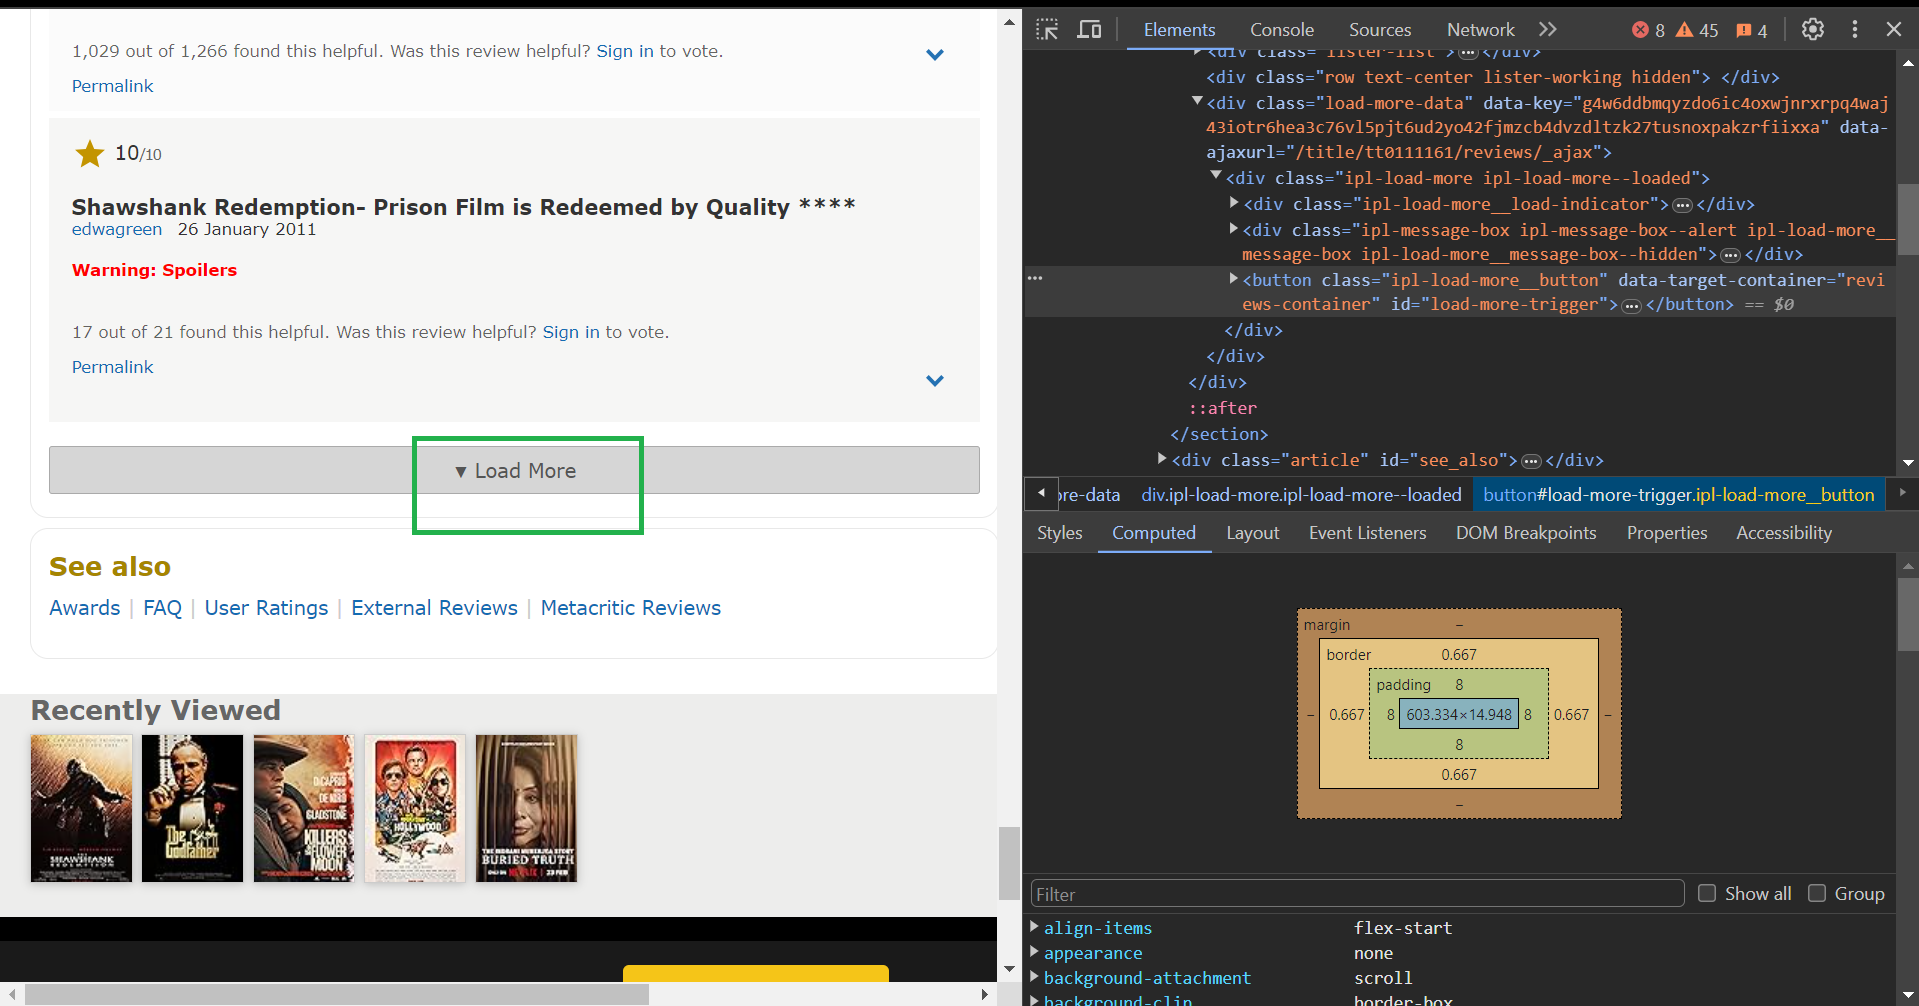
This will be done for 20 movies and we will be getting more than 20000 rows of data

In [18]:
# Function to extract reviews from a single movie's page


def extract_reviews(url, movie_name):
    # Setting up the Chrome WebDriver
    s = Service()
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=s, options=options)
    driver.get(url)

    wait = WebDriverWait(driver, 10)  # Wait up to 10 seconds before timing out
    button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="imdb-bmo-footer"]/div/div/div[2]/div/button[2]')))

    # Click the element once it's clickable
    button.click()
    # Wait for the "Load More" button and click it 40 times
    for i in range(40):
        try:
            load_more_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.ID, "load-more-trigger"))
            )
            load_more_button.click()
            time.sleep(1)  # Adjust timing as necessary.
        except Exception as e:
            print(e)
            break

    # Now extract the reviews
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    review_containers = soup.find_all('div', class_='review-container')
    reviews = []
    
    for review in review_containers:
        review_details = {
            'Username': None,
            'Review Title': None,
            'Review Rating': None,
            'Review Date': None,
            'Review Content': None,
            'Movie Name': movie_name
        }
        
        # Extract the review details as before...
        #Extract review username
        username_tag = review.find('span', class_='display-name-link')
        review_details['Username'] = username_tag.a.text.strip() if username_tag else None
    
        # Extract review title
        review_title_tag = review.find('a', class_='title')
        review_details['Review Title'] = review_title_tag.text.strip() if review_title_tag else None
    
        # Extract review rating
        review_rating_tag = review.find('span', class_='rating-other-user-rating')
        review_details['Review Rating'] = review_rating_tag.span.text if review_rating_tag and review_rating_tag.span else None
    
        # Extract review date
        review_date_tag = review.find('span', class_='review-date')
        review_details['Review Date'] = review_date_tag.text if review_date_tag else None
    
        # Extract review content
        review_content_tag = review.find('div', class_='text')
        review_details['Review Content'] = review_content_tag.text.strip() if review_content_tag else None        
        reviews.append(review_details)
    
    return reviews

# DataFrame to hold all movies' reviews
all_movies_reviews = []

# Loop through the first 20 movies
for index, row in movies_df.head(20).iterrows():
    movie_reviews = extract_reviews(row['User Reviews URL'], row['Title'])
    all_movies_reviews.extend(movie_reviews)

# Convert the list of all movies' reviews to a DataFrame
all_movies_reviews_df = pd.DataFrame(all_movies_reviews)

# Close the driver
driver.quit()

# Display the DataFrame
display(all_movies_reviews_df)

# Save to CSV
all_movies_reviews_df.to_csv('all_movies_reviews.csv', index=False)


,Username,Review Title,Review Rating,Review Date,Review Content,Movie Name
0,hitchcockthelegend,Some birds aren't meant to be caged.,10,24 July 2010,The Shawshank Redemption is written and direct...,The Shawshank Redemption
1,Sleepin_Dragon,An incredible movie. One that lives with you.,10,17 February 2021,It is no wonder that the film has such a high ...,The Shawshank Redemption
2,EyeDunno,Don't Rent Shawshank.,10,21 November 2005,I'm trying to save you money; this is the last...,The Shawshank Redemption
3,alexkolokotronis,This is How Movies Should Be Made,10,18 February 2008,This movie is not your ordinary Hollywood flic...,The Shawshank Redemption
4,auuwws,the shawshank redemption,10,8 October 2020,The best movie in history and the best ending ...,The Shawshank Redemption
...,...,...,...,...,...,...
20157,OllieZ,A classic crime thriller.,10,29 July 2003,A much more disturbing movie than Silence of t...,Se7en
20158,MichaelIversen,great,10,21 August 2022,Great movie. A film masterpiece. Out of all th...,Se7en
20159,lreilly2,Brad Pitt is Mediocre,None,17 June 2004,I don't know if Brad Pitt is just a so-so acto...,Se7en
20160,trminator-35198,Emotionally draining,7,17 January 2019,A well written film that is very hard to watch...,Se7en


## Data Cleaning

As a part of Data Cleaning for the review content column below are the steps we will be following the below steps

* Checking and removing Null Values.
* Checking and removing Duplicate Values.
* Converting all the the content text to lower cases.
* Removing any punctuations
* Using nltk library to remove all the stop words.
* Removing any html hyperlinks.

In [19]:
print(all_movies_reviews_df.isnull().sum())

Username             0
Review Title         0
Review Rating     1498
Review Date          0
Review Content       0
Movie Name           0
dtype: int64


In [20]:
#Drop Missing ratings
all_movies_reviews_df.dropna(inplace=True)

In [21]:
print(all_movies_reviews_df.isnull().sum())

Username          0
Review Title      0
Review Rating     0
Review Date       0
Review Content    0
Movie Name        0
dtype: int64


In [22]:
all_movies_reviews_df.drop_duplicates(subset=['Username', 'Review Title', 'Review Date'], keep='first', inplace=True)

In [38]:
all_movies_reviews_df['Review Content_Clean'] = all_movies_reviews_df['Review Content'].str.lower()

In [39]:
# Punctuation removal
all_movies_reviews_df['Review Content_Clean'] = all_movies_reviews_df['Review Content_Clean'].str.replace(r'[^\w\s]', '', regex=True)

In [40]:
# Removing Stop Words for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords set
nltk.download('punkt')
nltk.download('stopwords')

# Load stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Apply the function to the "Review Content_Clean" column
all_movies_reviews_df['Review Content_Clean'] = all_movies_reviews_df['Review Content_Clean'].apply(remove_stop_words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:

url_pattern = r'https?://[^\s]+|www\.[^\s]+'

# Replace URLs with an empty string
all_movies_reviews_df['Review Content_Clean'] = all_movies_reviews_df['Review Content_Clean'].str.replace(url_pattern, '', regex=True)

In [43]:
all_movies_reviews_df.to_csv('all_movies_reviews_cleaned.csv', index=False)

In [44]:
all_movies_reviews_df.head()

,Username,Review Title,Review Rating,Review Date,Review Content,Movie Name,Review Content_Clean
0,hitchcockthelegend,Some birds aren't meant to be caged.,10,24 July 2010,The Shawshank Redemption is written and direct...,The Shawshank Redemption,shawshank redemption written directed frank da...
1,Sleepin_Dragon,An incredible movie. One that lives with you.,10,17 February 2021,It is no wonder that the film has such a high ...,The Shawshank Redemption,wonder film high rating quite literally breath...
2,EyeDunno,Don't Rent Shawshank.,10,21 November 2005,I'm trying to save you money; this is the last...,The Shawshank Redemption,im trying save money last film title consider ...
3,alexkolokotronis,This is How Movies Should Be Made,10,18 February 2008,This movie is not your ordinary Hollywood flic...,The Shawshank Redemption,movie ordinary hollywood flick great deep mess...
4,auuwws,the shawshank redemption,10,8 October 2020,The best movie in history and the best ending ...,The Shawshank Redemption,best movie history best ending entertainment b...


In [48]:
all_movies_reviews_df.to_csv('all_movies_reviews_cleaned.csv', index=False)

## Emotion Labeling

As a part of emotion labeling we are bhadresh-savani/distilbert-base-uncased-emotion it is a BERT based model and a popular model with close to 500k monthly downloads.
This model will classify the review to one of 6 labels 
* Sadness
* Joy
* Fear
* Anger
* Surprise
* Love

The preprocessing of text is done as the model can accept only <b>512 tokens</b> of text.
Any text above the limit of 512 tokens will not be labelled.

In [6]:
from transformers import pipeline

# Load the pre-trained emotion classification model
classifier = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion")

# Define a function to classify emotions of the cleaned review content
def classify_emotion(text):
    try:
        # Predict the emotion
        results = classifier(text)
        # Extract the most likely emotion
        emotion = max(results, key=lambda result: result['score'])['label']
        return emotion
    except Exception as e:
        return None

all_movies_reviews_df['Emotion'] = all_movies_reviews_df['Review Content_Clean'].apply(classify_emotion)

Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors


## Data Cleaning Post Labeling

Data Cleaning is again done as few of the texts were still not classifed due to token length issue so those rows are removed.

In [22]:
print(all_movies_reviews_df.isnull().sum())

Username                  0
Review Title              0
Review Rating             0
Review Date               0
Review Content            0
Movie Name                0
Review Content_Clean      0
Emotion                 713
dtype: int64


In [23]:
#Drop Missing Emotions
all_movies_reviews_df.dropna(inplace=True)

In [24]:
print(all_movies_reviews_df.isnull().sum())

Username                0
Review Title            0
Review Rating           0
Review Date             0
Review Content          0
Movie Name              0
Review Content_Clean    0
Emotion                 0
dtype: int64


In [25]:
all_movies_reviews_df.to_csv('all_movies_reviews_cleaned.csv', index=False)

## Exploratory Data Analysis

Below part provides the Exploratory data analysis for our IMDB dataset

In [1]:
import pandas as pd
all_movies_reviews_df = pd.read_csv('all_movies_reviews_cleaned_emotions.csv')

In [2]:
all_movies_reviews_df.head()

,Username,Review Title,Review Rating,Review Date,Review Content,Movie Name,Review Content_Clean,Emotion
0,hitchcockthelegend,Some birds aren't meant to be caged.,10,24 July 2010,The Shawshank Redemption is written and direct...,The Shawshank Redemption,shawshank redemption written directed frank da...,sadness
1,Sleepin_Dragon,An incredible movie. One that lives with you.,10,17 February 2021,It is no wonder that the film has such a high ...,The Shawshank Redemption,wonder film high rating quite literally breath...,joy
2,EyeDunno,Don't Rent Shawshank.,10,21 November 2005,I'm trying to save you money; this is the last...,The Shawshank Redemption,im trying save money last film title consider ...,sadness
3,alexkolokotronis,This is How Movies Should Be Made,10,18 February 2008,This movie is not your ordinary Hollywood flic...,The Shawshank Redemption,movie ordinary hollywood flick great deep mess...,joy
4,auuwws,the shawshank redemption,10,8 October 2020,The best movie in history and the best ending ...,The Shawshank Redemption,best movie history best ending entertainment b...,joy


In [3]:
unique_emotions = all_movies_reviews_df['Emotion'].unique()

print(unique_emotions)

['sadness' 'joy' 'fear' 'anger' 'surprise' 'love']


In [4]:
codes, uniques = pd.factorize(all_movies_reviews_df['Emotion'])

# Add the codes as a new column to the DataFrame
all_movies_reviews_df['Emotion_Code'] = codes

# Print the mapping of emotions to codes
print(uniques)
print(codes)

Index(['sadness', 'joy', 'fear', 'anger', 'surprise', 'love'], dtype='object')
[0 1 0 ... 1 0 1]


In [5]:
all_movies_reviews_df.describe()

,Review Rating,Emotion_Code
count,17894.000000,17894.000000
mean,8.421873,1.278361
std,2.509895,1.090713
min,1.000000,0.000000
25%,8.000000,1.000000
50%,10.000000,1.000000
75%,10.000000,1.000000
max,10.000000,5.000000


## Insights for Review Rating

* Most of the ratings in our dataset have high scores which can be seen from the mean of 8.42.
* Low standard deviation implies there are less variations in review scores from the mean.

### Distribution of emotions across all the movie reviews

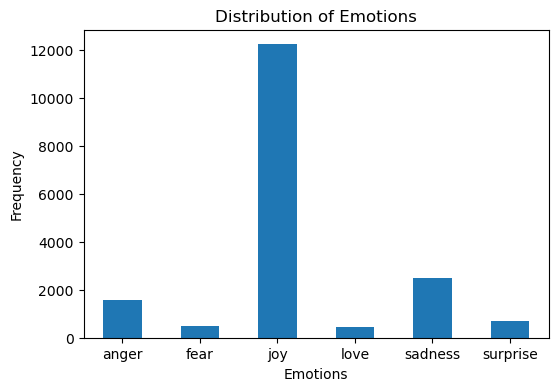

In [6]:
import matplotlib.pyplot as plt

# Assuming 'Emotion_Code' is the column with numeric emotion codes
emotion_counts = all_movies_reviews_df['Emotion'].value_counts()

# Sort the counts by emotion code to ensure the bars are in order
emotion_counts = emotion_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(6, 4))
emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(emotion_counts)), labels=emotion_counts.index, rotation=0) 
plt.show()

In [7]:
emotion_counts

Emotion
anger        1554
fear          479
joy         12221
love          454
sadness      2495
surprise      691
Name: count, dtype: int64

### Distribution of Ratings across all the 20 movies

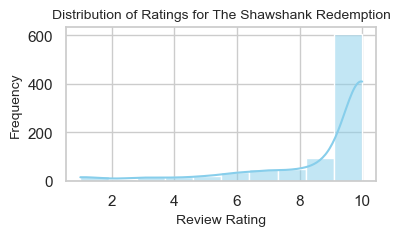

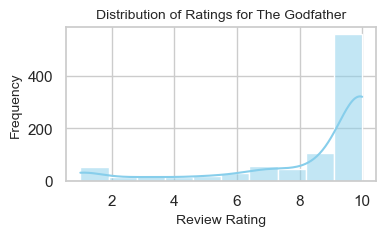

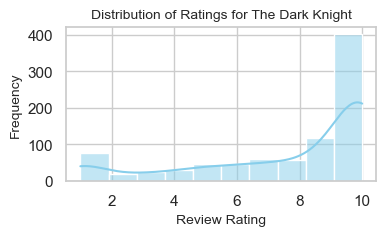

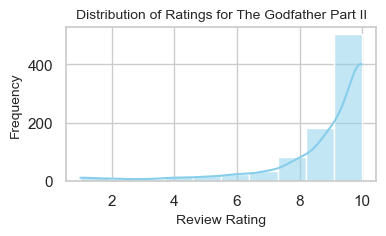

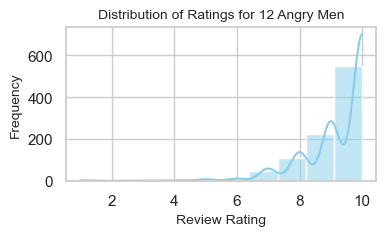

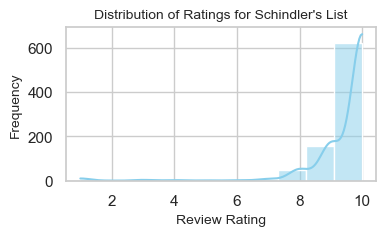

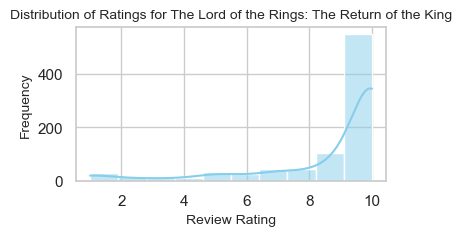

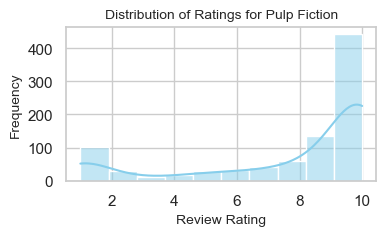

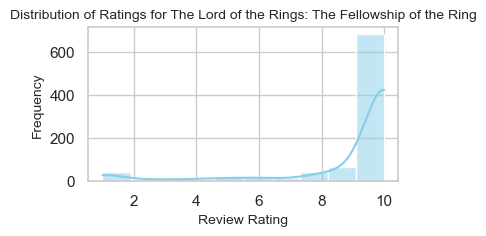

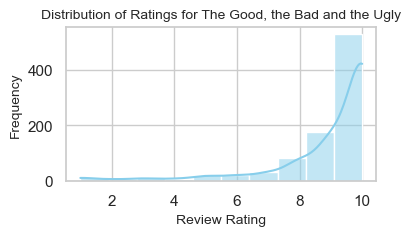

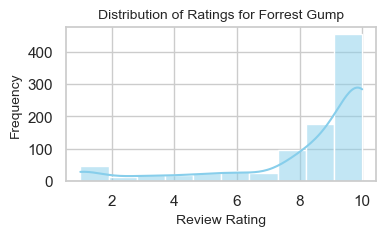

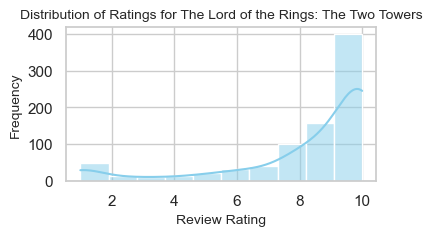

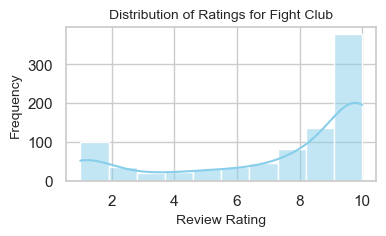

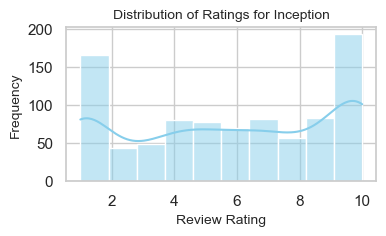

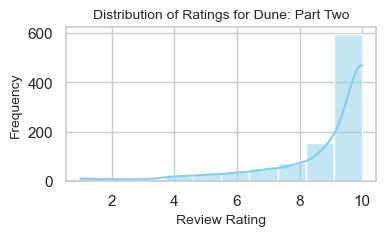

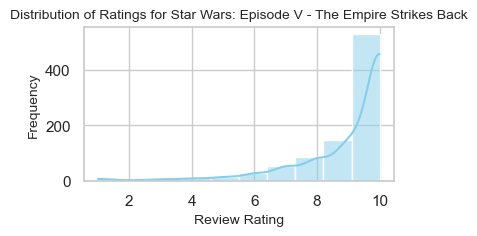

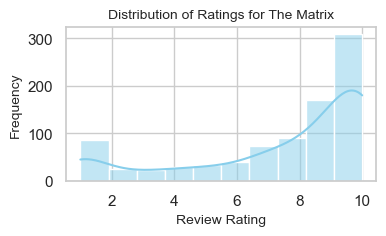

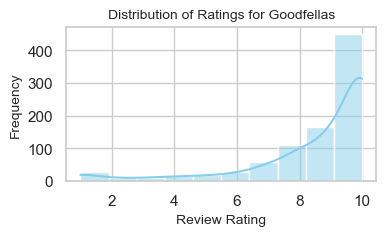

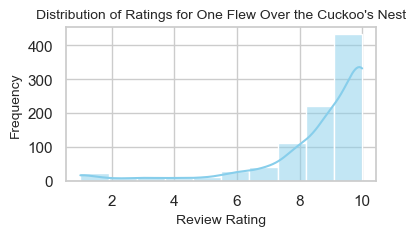

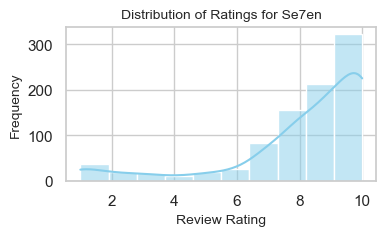

In [8]:
import seaborn as sns

sns.set(style="whitegrid")

# Loop through each unique movie in your dataset
for movie in all_movies_reviews_df['Movie Name'].unique():
    # Filter the DataFrame to only the current movie in the loop
    movie_df = all_movies_reviews_df[all_movies_reviews_df['Movie Name'] == movie]
    
    # Create a histogram for the review ratings of the current movie
    plt.figure(figsize=(4, 2)) # Set the figure size for better readability
    sns.histplot(data=movie_df, x='Review Rating', bins=10, kde=True, color='skyblue')
    
    # Title and labels
    plt.title(f'Distribution of Ratings for {movie}', fontsize=10)
    plt.xlabel('Review Rating', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    
    # Show the plot
    plt.show()


## Insights for Rating Distribution

* Since the dataset is for Top 20 rated movies from IMDB most of the review ratings are 10 and is enjoyed by the audience
* The distribution of ratings is heavily right-skewed, meaning that there are more high ratings than low ratings. The movies are favourable to the audience.
* Only Inception movie has more spread out rating, suggesting wide range of viewer opinions. 

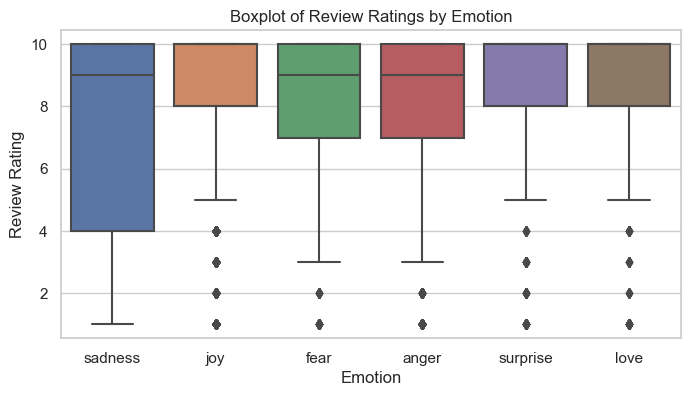

In [9]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=all_movies_reviews_df, x='Emotion', y='Review Rating')
plt.title('Boxplot of Review Ratings by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Review Rating')
plt.show()

### Insights for box plot
* It can be seen from the above box plot that rating is not directly correlated to the emotions of the user.
* Despite the dataset having a high average rating of 8.42, indicating overall positive reviews, emotions typically associated with negative experiences, such as anger and fear, are still present.

## Modeling Approach

* In our sentiment analysis model, we aim to predict the emotions conveyed in movie reviews. The target variable is 'Emotion_Code' category and our primary feature is 'Review Content_Clean' which consists of cleaned user review data.
* To effectively utilize this textual information for modeling, we will implement a Term Frequency-Inverse Document Frequency (TF-IDF) transformation. This technique quantifies the importance of each word in the review content relative to a collection of reviews. By transforming the text into a numerical representation, TF-IDF will highlight the words that are most characteristic and informative for each emotional category.
* The numerical features generated by TF-IDF will then serve as input variables for our classification model.
* The final model will be trained to recognize patterns in word usage and associate them with the corresponding emotions.

In [10]:
# Keeping only relevant features for modelling
model_df = all_movies_reviews_df.loc[:, ['Review Content_Clean', 'Emotion_Code']]

In [11]:
model_df.head()

,Review Content_Clean,Emotion_Code
0,shawshank redemption written directed frank da...,0
1,wonder film high rating quite literally breath...,1
2,im trying save money last film title consider ...,0
3,movie ordinary hollywood flick great deep mess...,1
4,best movie history best ending entertainment b...,1


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(model_df['Review Content_Clean']).toarray()

We are setting max_features to 5000 due to computational complexity and memory consumption as there are close to 18,000 rows of data.

In [13]:
from sklearn.model_selection import train_test_split

y = model_df['Emotion_Code']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initializing Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Fitting the model to the training data
logreg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}\n')
print(f'Classification Report:\n{report}')

Accuracy: 0.7177982676725342

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.26      0.36       514
           1       0.73      0.98      0.84      2438
           2       0.00      0.00      0.00       104
           3       0.53      0.12      0.19       295
           4       0.67      0.05      0.10       155
           5       0.75      0.08      0.15        73

    accuracy                           0.72      3579
   macro avg       0.55      0.25      0.27      3579
weighted avg       0.67      0.72      0.64      3579



C:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Insights from the initial modelling

* Classification of Joy(1) is more precise than other labels. This overrepresentation leads to the model being better trained to identify 'Joy' at the expense of other emotions.
* To address the dataset's imbalance and achieve a more uniform distribution of emotional categories, we plan to implement Synthetic Minority Over-sampling Technique (SMOTE). This approach will generate synthetic samples for underrepresented classes in the dataset, thereby enriching our training data. 

In [15]:
from imblearn.over_sampling import SMOTE

# Initializing SMOTE
smote = SMOTE(random_state=1)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Models

* Logistic Regression
* XG Boost
* Random Forest
* Ridge Classifier


In [24]:
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'Random Forest': RandomForestClassifier(),
    'Ridge Classifier': RidgeClassifier() 
}

# DataFrame to hold all the metrics
metrics_list = []
# Dictionary to store trained models
trained_models = {}
# Dictionary to store predictions
model_predictions = {}
# Evaluate each model
for model_name, model in models.items():
    start_time = time()
    model.fit(X_train_smote, y_train_smote)
    elapsed_time = time() - start_time
    
     # Store the trained model
    trained_models[model_name] = model
    
    # Predictions
    y_train_pred = model.predict(X_train_smote)
    y_test_pred = model.predict(X_test)
    model_predictions[model_name] = y_test_pred 
    
    # Calculating metrics
    accuracy_train = accuracy_score(y_train_smote, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Appending to DataFrame
    metrics_list.append({
        'Model': model_name,
        'Accuracy Train': accuracy_train,
        'Accuracy Testing': accuracy_test,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Time_Taken': elapsed_time
    })

metrics_df = pd.DataFrame(metrics_list)
display(metrics_df)

,Model,Accuracy Train,Accuracy Testing,Precision,Recall,F1_Score,Time_Taken
0,Logistic Regression,0.942843,0.618888,0.686470,0.618888,0.644306,58.543836
1,XGBoost,0.973151,0.698799,0.674875,0.698799,0.682193,242.634254
2,Random Forest,0.999983,0.678961,0.615871,0.678961,0.616137,69.217911
3,Ridge Classifier,0.947784,0.554624,0.668008,0.554624,0.593244,8.941174


##  Insights from the table

* From the above table it can be seen that XG Boost is the best model.
* XGBoost has the highest time taken to train(242 seconds) which is due to the number of features in the test variable.
* 2nd best model that can be used is Random Forest which has a high training accuracy(99%) compared to other models and has a good accuracy for test data (~68%).

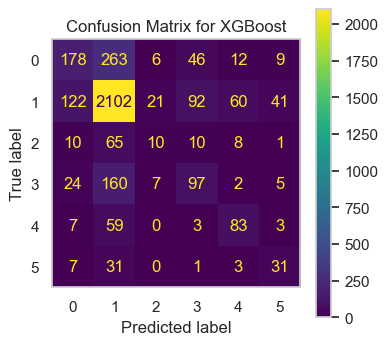

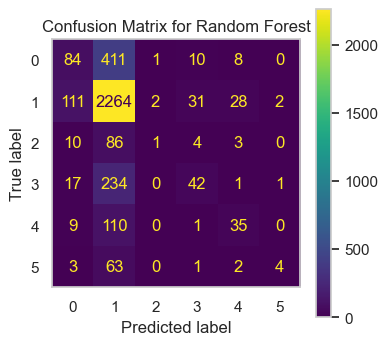

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

#For 2 models we are plotting the confusion matrix
models_to_include = ['XGBoost', 'Random Forest']


for model_name, y_pred in model_predictions.items():
    if model_name in models_to_include:
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.grid(False)
        display_labels = np.unique(np.concatenate((y_test, y_pred))) 
        ConfusionMatrixDisplay(cm, display_labels=display_labels).plot(ax=ax)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()


## Feature Importance Visualization for XGBoost

Understanding which features significantly influence the predictions of our Random Forest model can provide valuable insights. In the context of text classification, "features" typically refer to words or terms in our TF-IDF vectorized dataset. The feature importance scores indicate how much each word contributes to the model's decision-making process.

In this visualization, we plot the top 20 features based on their importance scores as determined by XG Boost classifier. Higher scores suggest a stronger influence on the classification outcomes. Analyzing these features can help us understand what the model deems relevant when categorizing emotions in movie reviews. This insight can be particularly useful for refining the model further or interpreting its predictions in the context of the dataset's specific domain.

By examining the plot, we can identify which words are most indicative of particular emotions according to the model. This not only aids in validating the model's rationale but can also highlight potential biases or areas for further investigation and improvement.

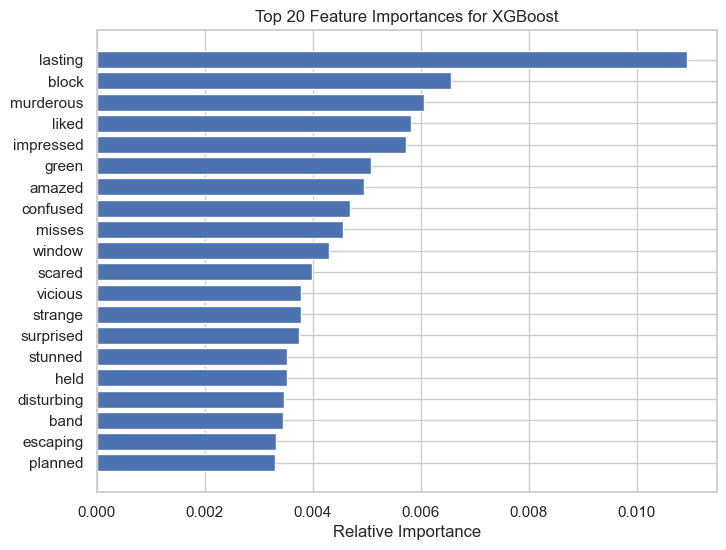

In [34]:
xgb_model = trained_models['XGBoost']

importances = xgb_model.feature_importances_

indices = np.argsort(importances)[-20:]

top20_importances = importances[indices]
top20_labels = np.array(tfidf_vectorizer.get_feature_names_out())[indices]

# Plotting the feature importances
plt.figure(figsize=(8, 6))
plt.title('Top 20 Feature Importances for XGBoost')
plt.barh(range(len(indices)), top20_importances, color='b', align='center')
plt.yticks(range(len(indices)), top20_labels)
plt.xlabel('Relative Importance')
plt.show()


## Testing the model

We are giving few sample text to the model to check its classification.

In [36]:
new_review_texts = ["this movie plot has holes everywhere making no sense", 
                    "an absolutely breathtaking masterpiece with stunning visuals"]

X_new = tfidf_vectorizer.transform(new_review_texts).toarray()

xgb_model= trained_models['XGBoost']
predicted_emotions_codes = xgb_model.predict(X_new)

predicted_emotions = [uniques[code] for code in predicted_emotions_codes]

# Display predicted emotions
for review, emotion in zip(new_review_texts, predicted_emotions):
    print(f"Review: {review}\nPredicted Emotion: {emotion}\n")

Review: this movie plot has holes everywhere making no sense
Predicted Emotion: anger

Review: an absolutely breathtaking masterpiece with stunning visuals
Predicted Emotion: joy



## Creating a pickle file for the best model

In [37]:
import pickle


xgb_model = trained_models['XGBoost']

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

## Conclusion

We have extracted substantial data through webscraping of imdb website and performed emotional analysis by labelling using another model.

The models we trained, particularly XGBoost and Random Forest are our best models. Training time is significantly high for xgboost compared to other models.

We also gained insights into the specific words that carry significant weight in the classification process, which could guide future content creation and audience analysis in the entertainment industry. The feature importance visualization underscored the value of certain terms in evoking emotions, that can be harnessed to tailor marketing strategies or enhance recommendation systems.

While our models show promising results, we recognize the path for improvement. Future work would involve hyper parameter tuning, feature engineering in addition to TF-IDF and using other models to label emotions. Due to computational and memory issues we could not completely use all the features as an input variable and restrict to 5000 features for TF-IDF. Additionally, we see a valuable opportunity in deploying these models into a real-time analysis tool that could track audience sentiment trends, providing immediate feedback to content creators and platforms.
